# Continuous anaerobic digestion

Did you know that there is 18000 commercial anaerobic digesters in Europe alone. You can have a look at this [website](https://www.europeanbiogas.eu/about-biogas-and-biomethane/) for more information. Most of these commercial digesters operate in a continuous mode, implying that steady state is achieved at most times. 



In this chapter we will be looking ant continuous anaerobic digestion and how the growth and maintenance 


Let's use the same description we had for the first part of chapter 6:



In [4]:
import numpy
import pandas
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

S1 = numpy.matrix(pandas.read_excel('matdig1.xlsx'))
S2 = numpy.matrix(pandas.read_excel('matdig2.xlsx'))

In [5]:
mumax=0.075 #1/day
thetamax=1/1000*(12+1.7+16*0.55+14*0.04)*24
muDmax=0.02
MMs=12+S1[1,0]+S1[2,0]*16+S1[3,0]*14
MMx=12+S1[1,1]+S1[2,1]*16+S1[3,1]*14
Km=1.5/MMs

In [6]:
def response_fun(C):
    
    Cs, Cx, Nch4, Nco2, Cnh3, Cr = C[0],C[1],C[2],C[3],C[4],C[5]
    
    mu= mumax*Cs/(Km+Cs)
    muD=muDmax*Cs/(Km+Cs)
    theta=thetamax*Cs/(Km+Cs)

    C1 = numpy.matrix([[0,0,0,0,mu,0,theta]]).T  #Growth rate specified
    C2 = numpy.matrix([[0,0,0,0,muD]]).T   #Death rate specified

    r1 = numpy.linalg.solve(S1,C1)
    r2 = numpy.linalg.solve(S2,C2)
    
    return [r1[0,0],           # rs
            r1[1,0]+r2[0,0],   # rx
            r1[2,0]+r2[2,0],   # rch4
            r1[3,0]+r2[3,0],   #rco2
            r1[5,0]+r2[1,0],   #rnh3
            r1[6,0]]           #rr   


\begin{align*}
\frac{dC_i}{dt} &= D(C^F_i - C_i) + r_i C_X \\
\end{align*}


In [7]:
V=2 #L

For the gaseous components $CH_4$ and $CO_2$ there is zero inlet or outlet flow through the liquid. All biogas formed leaves the digester directly. 

In [8]:
def ferm_eq(t,C):
    
    Cs, Cx, Nch4, Nco2, Cnh3, Cr = C[0],C[1],C[2],C[3],C[4],C[5]  # order of components very important 
    
    r=response_fun([Cs, Cx, Nch4, Nco2, Cnh3, Cr])      # this is the 'fetching' from the response function
    
    dcsdt=D*(Cf[0]-C[0]) +  r[0]*Cx
    dcxdt=D*(Cf[1]-C[1]) +  r[1]*Cx
    dNch4dt=r[2]*Cx*V
    dNco2dt=r[3]*Cx*V
    dcndt=D*(Cf[4]-C[4]) +  r[4]*Cx
    dcrdt=D*(Cf[5]-C[5]) +  r[5]*Cx
    
    return [dcsdt,
            dcxdt,
            dNch4dt,
            dNco2dt,
            dcndt,
            dcrdt] 

In [12]:
Co=[3/MMs,0,0,0,0,0]
D=1/20 #dilution rate
Cf=[40/MMs,0/MMx,0,0,0,0]

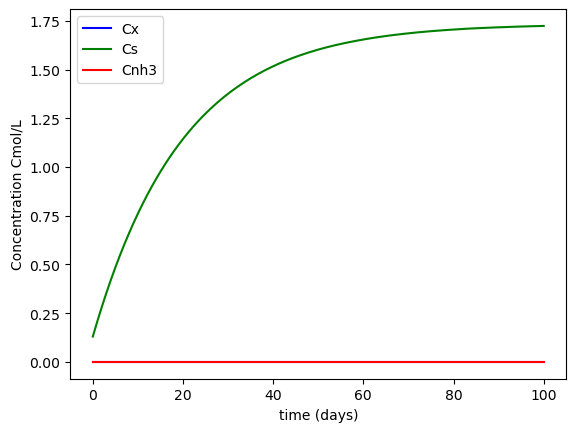

In [13]:
tmax = 100                               # time to integrate to  
tspan=numpy.linspace(0,tmax,200)            # define the timespan of the integration and increments where values will be reported
tper = (0,tmax)                          #defining the starting and end time for the solve_IVP function

CorNi = solve_ivp(ferm_eq, tper, Co, dense_output = True, method = "LSODA")    # integration via odeint that calls apon response_fun

Cs, Cx, Nch4, Nco2, Cnh3,Cr = CorNi.sol(tspan)

plt.figure(3)
plt.plot(tspan, Cx, color='blue', label='Cx')
plt.plot(tspan, Cs, color='green', label='Cs')
plt.plot(tspan, Cnh3, color='red', label='Cnh3')
plt.legend(loc='best')
plt.ylabel('Concentration Cmol/L') 
plt.xlabel('time (days)') 
plt.show() 

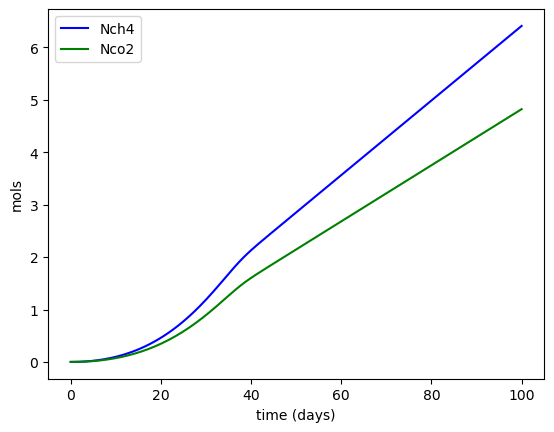

In [11]:
plt.figure(4)
plt.plot(tspan, Nch4, color='blue', label='Nch4')
plt.plot(tspan, Nco2, color='green', label='Nco2')
plt.legend(loc='best')
plt.ylabel('mols') 
plt.xlabel('time (days)') 
plt.show() 

Get the rates of gas production


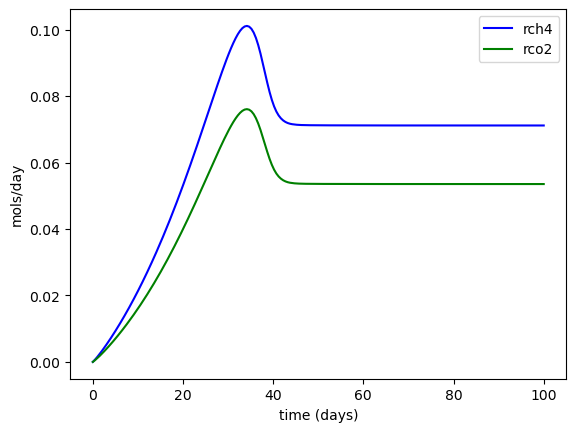

In [17]:
CorN2=CorNi.sol(tspan).T
r = numpy.asarray([response_fun(C) for C in CorN2])

rch4=r[:,2]*Cx*V
rco2=r[:,3]*Cx*V

plt.figure(5)
plt.plot(tspan, rch4, color='blue', label='rch4')
plt.plot(tspan, rco2, color='green', label='rco2')
plt.legend(loc='best')
plt.ylabel('mols/day') 
plt.xlabel('time (days)') 
plt.show() 



In [10]:
def ferm_eq_ss(C):
    
    Cs, Cx, Cnh3, Cr = C[0],C[1],C[2],C[3]  # order of components very important 
    
    r=response_fun([Cs, Cx, 0, 0, Cnh3, Cr])      # this is the 'fetching' from the response function
    
    dcsdt=D*(Cf[0]-C[0]) +  r[0]*Cx
    dcxdt=D*(Cf[1]-C[1]) +  r[1]*Cx
    dcndt=D*(Cf[4]-C[2]) +  r[4]*Cx
    dcrdt=D*(Cf[5]-C[3]) +  r[5]*Cx
    
    return [dcsdt,
            dcxdt,
            dcndt,
            dcrdt] 

In [19]:
[Cs[-1], Cx[-1], Cnh3[-1], Cr[-1]]

[0.04528802445034564,
 0.13455544554772925,
 0.05208405554793927,
 0.33567698691949155]

In [12]:
from scipy.optimize import fsolve
guess=[0.05,0.1,0.05,0.25]
steadystate=fsolve(ferm_eq_ss,guess)
steadystate

array([0.04476798, 0.1354747 , 0.05243945, 0.33796748])